# Latent HGF: BA Project

In [1]:
import sys
from IPython.utils import io

In [2]:
# if 'google.colab' in sys.modules:

#   with io.capture_output() as captured:
#      ! pip install pyhgf watermark

In [3]:
from typing import Dict, Tuple

from pyhgf.typing import AdjacencyLists, Edges
from pyhgf.utils import add_edges


def add_parent(
    attributes: Dict, edges: Edges, index: int, coupling_type: str, mean: float
) -> Tuple[Dict, Edges]:
    r"""Add a new continuous-state parent node to the attributes and edges of an
    existing network.

    Parameters
    ----------
    attributes :
        The attributes of the existing network.
    edges :
        The edges of the existing network.
    index :
        The index of the node you want to connect a new parent node to.
    coupling_type :
        The type of coupling you want between the existing node and it's new parent.
        Can be either "value" or "volatility".
    mean :
        The mean value of the new parent node.

    Returns
    -------
    attributes :
        The updated attributes of the existing network.
    edges :
        The updated edges of the existing network.

    """
    # Get index for node to be added
    new_node_idx = len(edges)

    # Add new node to attributes
    attributes[new_node_idx] = {
        "mean": mean,
        "expected_mean": mean,
        "precision": 1.0,
        "expected_precision": 1.0,
        "volatility_coupling_children": None,
        "volatility_coupling_parents": None,
        "value_coupling_children": None,
        "value_coupling_parents": None,
        "tonic_volatility": -4.0,
        "tonic_drift": 0.0,
        "autoconnection_strength": 1.0,
        "observed": 1,
        "temp": {
            "effective_precision": 0.0,
            "value_prediction_error": 0.0,
            "volatility_prediction_error": 0.0,
        },
    }

    # Add new AdjacencyList with empty values, to Edges tuple
    new_adj_list = AdjacencyLists(
        node_type=2,
        value_parents=None,
        volatility_parents=None,
        value_children=None,
        volatility_children=None,
        coupling_fn=(None,),
    )
    edges = edges + (new_adj_list,)

    # Use add_edges to integrate the altered attributes and edges
    attributes, edges = add_edges(
        attributes=attributes,
        edges=edges,
        kind=coupling_type,
        parent_idxs=new_node_idx,
        children_idxs=index,
    )

    # Return new attributes and edges
    return attributes, edges


In [4]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import jax
import pandas as pd
import networkx as nx

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF, Network
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.utils import beliefs_propagation
from pyhgf.math import gaussian_surprise
from copy import deepcopy
# from pyhgf.updates.structure import add_parent


plt.rcParams["figure.constrained_layout.use"] = True

In [5]:
# Disable JIT compilation globally
jax.config.update("jax_disable_jit", False) # True - If I want the compiler disabled.

In [6]:
# from pyhgf.updates.structure import add_parent

def update_structure(
        attributes: Dict, edges: Edges, index: int
) -> Tuple[Dict, Edges]:
    #Calculate gaussian-surprise
    if index >= 0:
            node_ex_m = (attributes[index]['expected_mean'])
            node_ex_p = (attributes[index]['expected_precision'])
            node_m = (attributes[index]['mean'])
            surprise = gaussian_surprise(x=node_m, 
                                     expected_mean=node_ex_m, 
                                     expected_precision=node_ex_p)
    else:
         return attributes, edges

    #Define threshold, and compare against calculated surprise 
    # (may need internal storage for accumulated storage)
    if surprise > 800:
        threshold_reached = True
    else:
        threshold_reached = False
    
    #Return attributes and edges
    if threshold_reached is False:
        return attributes, edges
    elif threshold_reached is True:
        print('new node added')
        return add_parent(attributes = attributes, 
                          edges = edges, 
                          index = index, 
                          coupling_type = 'volatility', #Add condition to vary
                          mean = 1.0
                          )

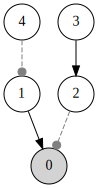

In [7]:
timeserie = load_data("continuous")

test_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
               value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-14.0, volatility_children=0)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
               value_children=2)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
    # .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
    #          value_children=2)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=2)
).create_belief_propagation_fn()

attributes, edges, update_sequence = (
    test_hgf.get_network()
)

# np.random.seed(123)
# dist_mean, dist_std = 5, 1
# input_data = np.random.normal(loc=dist_mean, scale=dist_std, size=10000)

aarhus_weather_df = pd.read_csv(
    "https://raw.githubusercontent.com/ilabcode/hgf-data/main/datasets/weather.csv"
)
aarhus_weather_df.head()
weather_data = aarhus_weather_df["t2m"][: 24 * 30].to_numpy()

test_hgf.plot_network()

In [8]:
edges

(AdjacencyLists(node_type=2, value_parents=(1,), volatility_parents=(2,), value_children=None, volatility_children=None, coupling_fn=()),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=(4,), value_children=(0,), volatility_children=None, coupling_fn=(None,)),
 AdjacencyLists(node_type=2, value_parents=(3,), volatility_parents=None, value_children=None, volatility_children=(0,), coupling_fn=()),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=None, value_children=(2,), volatility_children=None, coupling_fn=(None,)),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=None, value_children=None, volatility_children=(1,), coupling_fn=()))

In [10]:
# for each observation
for value in weather_data:

    # interleave observations and masks
    data = (value, 1.0, 1.0)

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=data,
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=test_hgf.input_idxs
    )

    #Calculate gaussian surprise
    index_vec = []
    nr = 0
    for node in edges:
        index_vec.append(nr)
        nr = nr+1


    for idx in index_vec:
        attributes, edges = update_structure(attributes = attributes, edges = edges, index = idx)
    


new node added
new node added


In [11]:
edges

(AdjacencyLists(node_type=2, value_parents=(1,), volatility_parents=(2, 5, 6), value_children=None, volatility_children=None, coupling_fn=()),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=(4,), value_children=(0,), volatility_children=None, coupling_fn=(None,)),
 AdjacencyLists(node_type=2, value_parents=(3,), volatility_parents=None, value_children=None, volatility_children=(0,), coupling_fn=()),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=None, value_children=(2,), volatility_children=None, coupling_fn=(None,)),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=None, value_children=None, volatility_children=(1,), coupling_fn=()),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=None, value_children=None, volatility_children=(0,), coupling_fn=(None,)),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=None, value_children=None, volatility_children=(0,), coupling_fn=(None,)))

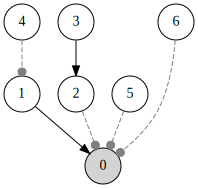

In [12]:
test_hgf.attributes = attributes
test_hgf.edges = edges

test_hgf.plot_network()

In [13]:
def create_hgf_visualization(input_data, attributes_history, edges_history, plot_interval=200):
    """
    Create a comprehensive visualization of HGF network and time series
    
    Parameters:
    - input_data: Original input time series
    - attributes_history: List of attributes at each plot interval
    - edges_history: List of edges at each plot interval
    - plot_interval: Number of trials between network snapshots
    """
    # Calculate number of subplots
    num_plots = len(attributes_history)
    
    # Create a figure with a grid layout
    # We'll have 3 columns: time series, network, and a placeholder
    fig = plt.figure(figsize=(20, 5 * num_plots))
    grid = fig.add_gridspec(num_plots, 3, width_ratios=[2, 1, 0])
    
    # Plot time series
    for i in range(num_plots):
        ax_series = fig.add_subplot(grid[i, 0])
        
        # Plot input data up to this point
        end_idx = (i + 1) * plot_interval
        ax_series.plot(input_data[:end_idx], label='Input Data')
        ax_series.set_title(f'Time Series at Trial {end_idx}')
        ax_series.set_xlabel('Trial Number')
        ax_series.set_ylabel('Input Value')
        ax_series.legend()
    
    # Plot network structures
    for i in range(num_plots):
        ax_network = fig.add_subplot(grid[i, 1])
        
        # Create a graph from the current network structure
        G = nx.DiGraph()
        
        # Get current attributes and edges
        current_attributes = attributes_history[i]
        current_edges = edges_history[i]
        
        # Add nodes with their current values
        for j, attr in enumerate(current_attributes):
            G.add_node(j, value=attr)
        
        # Add edges
        for edge in current_edges:
            G.add_edge(edge[0], edge[1])
        
        # Draw the network
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightblue', 
                node_size=500, ax=ax_network)
        
        # Annotate node values
        node_labels = {node: f'{node}: {attr:.2f}' 
                       for node, attr in enumerate(current_attributes)}
        nx.draw_networkx_labels(G, pos, labels=node_labels, ax=ax_network)
        
        ax_network.set_title(f'Network Structure at Trial {(i+1)*plot_interval}')
    
    plt.tight_layout()
    return fig

In [14]:
attributes_hist = []
edges_hist = []

attributes_hist.append(attributes)
edges_hist.append(edges)

ValueError: None cannot be a node

C:\Users\hesse\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
C:\Users\hesse\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


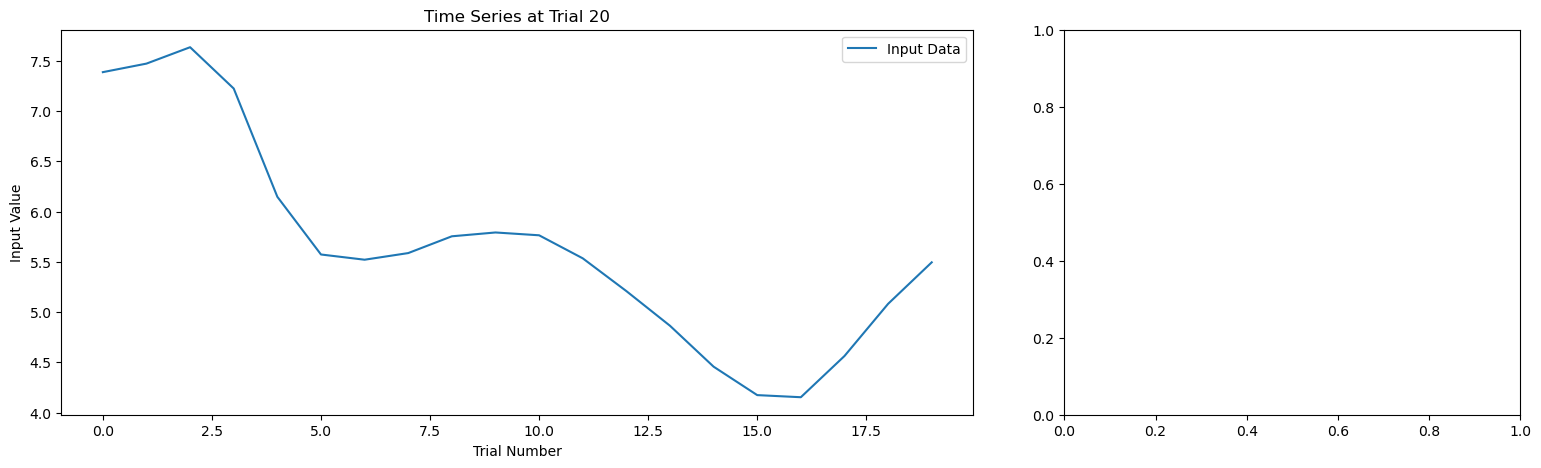

In [16]:
create_hgf_visualization(weather_data, attributes_hist, edges_hist, 20)